# IMAGE CAPTIONING

<b> We as a human being can easily describe what is there in the image by just looking into the picture but can computer do it automatically . Earlier it was impossible to get relevant features from the image and describe it into appropriate words but with the advancement of neural network it is possible to generate a relevant caption from a image.

<b> I will be using Flick8k dataset which containg 8k images and relevant caption about that particular image which can be easily downloaded by following this link. https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/

### ARCHITECTURE  

<b> I will be using a basic encoder-decoder architecture in using encoder will be a pretrained CNN while decoder consist of a LSTM layer

### EXPLORATORY DATA ANALYSIS and DATA PREPROCESSING

Importing necessary libraries

In [1]:
import tensorflow
import keras
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.translate import bleu_score
import string
import json
from time import time
import pickle as pkl
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
import numpy as np
import regex as re
import collections
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf
import datetime

All the captions for all images(train,dev,test) are stored in a text file  in Flickr8k.token.txt

In [2]:
captions=[]
with open("./storage/Flickr8k_text/Flickr8k.token.txt") as f :
    for line in f.readlines():
        captions.append(line[:-1])

In [3]:
#Creatng a dictionary  map all the captions for a image
all_description={}
for x in captions :
        first , second = x.split('\t')
        img_id = first.split('.')[0]
         #if the image is present or not
        if all_description.get(img_id) is None :
            all_description[img_id]=[]
        all_description[img_id].append(second)

In [4]:
print("Total number of images in our dataset is {}".format(len(all_description.keys())))

Total number of images in our dataset is 8092


Our all_description dictionary contain image_id as key and all the relevant captions into an list as value of the key . All images have 5 relevant captions against it

#### PREPROCESSING TEXT 

In [5]:
def preprocess_text(x) :
    x=x.strip()
    x=x.lower()
    #Apart from a to z we are substituting with space
    x=re.sub("[^a-z]+" ," ",x)
    #Removing all the single letter words it will give grammatical mistake but it's ok 
    x = x.split()
    x=[s for s in x if len(s) > 1] 
    x = " ".join(x)
    return x

In [6]:
#Cleaning all tha captions
for key , caption_list in all_description.items() :
    for i in range(len(caption_list)) :
        caption_list[i]=preprocess_text(caption_list[i])

In [7]:
#Creating vocabulary
vocab=set()
for key in all_description.keys() :
    [vocab.update(x.split()) for x in all_description[key]]
    
print("Total size of vocab is {}".format(len(vocab)))

Total size of vocab is 8424


In [8]:
#Total words
total_words=[]
for key in all_description.keys() :
    [total_words.append(i) for des in all_description[key] for i in des.split()]

print("Total words are {}".format(len(total_words)))

Total words are 373837


<b> There are total 373837 which is way too much so i will try to reduce it and only consider words that are more frequent i will consider only words that occur more than 10 times

In [9]:
#Creating vocab
counter=collections.Counter(total_words)
freq_count=dict(counter)
#Sort this dictionary according to frequency count
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x : x[1])
#Filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1] >threshold]
total_words=[x[0] for x in sorted_freq_count]

In [10]:
print("Total number of words are {}".format(len(total_words)))

Total number of words are 1845


<b> Let's create two dictionaries one from word to index second index to words which wil be helpful in vectorizing captions

In [11]:
word_to_index = {}
index_to_word={}

for i , word in enumerate(total_words) :
    word_to_index[word] = i+1
    index_to_word[i+1] = word 

In [12]:
#Appending startseq and endseq
index_to_word[1846] = "startseq"
word_to_index["startseq"]=1846

index_to_word[1847] = "endseq"
word_to_index["endseq"]=1847

In [13]:
with open("./storage/Flickr8k_text/Flickr_8k.trainImages.txt",'r') as f :
    train_file_data=f.read()
with open("./storage/Flickr8k_text/Flickr_8k.devImages.txt",'r') as f :
    valid_file_data=f.read()
with open("./storage/Flickr8k_text/Flickr_8k.testImages.txt",'r') as f :
    test_file_data=f.read()

In [14]:
train=[row.split(".")[0] for row in train_file_data.split('\n')[:-1]]
valid=[row.split(".")[0] for row in valid_file_data.split('\n')[:-1]]
test=[row.split(".")[0] for row in test_file_data.split('\n')[:-1]]

In [15]:
#Prepare start and end seqeuence
train_description={}
for img_id in train :
    train_description[img_id] = []
    for caption in all_description[img_id] :
        caption_mod = "startseq " + caption +" endseq"
        train_description[img_id].append(caption_mod)
        

In [16]:
test_description={}
for img_id in test :
    test_description[img_id] = []
    for caption in all_description[img_id] :
        caption_mod = "startseq " + caption +" endseq"
        test_description[img_id].append(caption_mod)

In [17]:
valid_description={}
for img_id in valid :
    valid_description[img_id] = []
    for caption in all_description[img_id] :
        caption_mod = "startseq " + caption +" endseq"
        valid_description[img_id].append(caption_mod)

In [18]:
vocab_size= len(word_to_index) + 1 
print("Vocabulary size {}".format(vocab_size))

Vocabulary size 1848


In [19]:
#Finding maximum length
max_len=0
for key in train_description.keys() :
    for cap in train_description[key] :
        max_len=max(max_len,len(cap.split()))
print(max_len)

35


#### IMAGE PREPROCESSING

In [20]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [21]:
model_new=Model(model.input,model.layers[-2].output)

In [22]:
def preprocess_img(img) :
    img=plt.imread(img)
    img=cv2.resize(img,(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((2048,))
    return feature_vector

In [23]:
IMG_PATH="./storage/Flickr8k_Dataset/Flicker8k_Dataset/"

In [24]:
encodedimg_train={}
#imageid-->extracted from resnet
count=0
for img_id in train :
    img_path=IMG_PATH+img_id+".jpg"
    encodedimg_train[img_id] = preprocess_img(img_path)
    count=count+1
    
    if count%100 == 0 :
        print("Encoding in progress {}".format(count))

1/1 [==============================] - 0s 19ms/step
Encoding in progress 100
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
Encoding in progress 200
1/1 [==============================] - 0s 31ms/step
Encoding in progress 300
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 9ms/step
Encoding in progress 400
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 8ms/step
Encoding in progress 500
1/1 [==============================] - 0s 25ms/step
Encoding in progress 600
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 36ms/step
Encoding in progress 700
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 800
1/1 [==============================] - 0s 25ms/step
Encoding in progress 900
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 28ms/step
Encoding in progress 1000
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step
Encoding in progress 1100
1/1 [==============================] - 0s 10ms/step
Encoding in progress 1200
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
Encoding in progress 1300
1/1 [==============================] - 0s 15ms/step
Encoding in progress 1400
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Encoding in progress 1500
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 1600
1/1 [==============================] - 0s 17ms/step
Encoding in progress 1700
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 15ms/step
Encoding in progress 1800
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Encoding in progress 1900
1/1 [==============================] - 0s 17ms/step
Encoding in progress 2000
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 8ms/step
Encoding in progress 2100
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step
Encoding in progress 2200
1/1 [==============================] - 0s 13ms/step
Encoding in progress 2300
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step
Encoding in progress 2400
1/1 [==============================] - 0s 27ms/step
Encoding in progress 2500
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 2600
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 25ms/step
Encoding in progress 2700
1/1 [==============================] - 0s 34ms/step
Encoding in progress 2800
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 2900
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Encoding in progress 3000
1/1 [==============================] - 0s 24ms/step
Encoding in progress 3100
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step
Encoding in progress 3200
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 3300
1/1 [==============================] - 0s 16ms/step
Encoding in progress 3400
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 3500
1/1 [==============================] - 0s 21ms/step
Encoding in progress 3600


1/1 [==============================] - 0s 28ms/step
Encoding in progress 3700
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 3800
1/1 [==============================] - 0s 16ms/step
Encoding in progress 3900
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 4000
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 4100
1/1 [==============================] - 0s 31ms/step
Encoding in progress 4200
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 4300
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step
Encoding in progress 4400
1/1 [==============================] - 0s 23ms/step
Encoding in progress 4500
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step
Encoding in progress 4600
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 36ms/step
Encoding in progress 4700
1/1 [==============================] - 0s 26ms/step
Encoding in progress 4800
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step
Encoding in progress 4900
1/1 [==============================] - 0s 28ms/step
Encoding in progress 5000
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step
Encoding in progress 5100
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 30ms/step
Encoding in progress 5200
1/1 [==============================] - 0s 34ms/step
Encoding in progress 5300
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step
Encoding in progress 5400
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 5500
1/1 [==============================] - 0s 30ms/step
Encoding in progress 5600
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 34ms/step
Encoding in progress 5700
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step
Encoding in progress 5800
1/1 [==============================] - 0s 30ms/step
Encoding in progress 5900
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 35ms/step
Encoding in progress 6000


In [25]:
encodedimg_test={}
count=0
for img_id in test :
    img_path=IMG_PATH+img_id+".jpg"
    encodedimg_test[img_id] = preprocess_img(img_path)
    count=count+1
    
    if count%100 == 0 :
        print("Encoding in progress {}".format(count))

1/1 [==============================] - 0s 32ms/step
Encoding in progress 100
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step
Encoding in progress 200
1/1 [==============================] - 0s 33ms/step
Encoding in progress 300
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step
Encoding in progress 400
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step
Encoding in progress 500
1/1 [==============================] - 0s 35ms/step
Encoding in progress 600
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 700
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step
Encoding in progress 800
1/1 [==============================] - 0s 26ms/step
Encoding in progress 900
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step
Encoding in progress 1000


In [26]:
encodedimg_valid={}
count=0
for img_id in valid :
    img_path=IMG_PATH+img_id+".jpg"
    encodedimg_valid[img_id] = preprocess_img(img_path)
    count=count+1
    
    if count%100 == 0 :
        print("Encoding in progress {}".format(count))

1/1 [==============================] - 0s 21ms/step
Encoding in progress 100
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step
Encoding in progress 200
1/1 [==============================] - 0s 22ms/step
Encoding in progress 300
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 29ms/step
Encoding in progress 400
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 16ms/step
Encoding in progress 500
1/1 [==============================] - 0s 19ms/step
Encoding in progress 600
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 20ms/step
Encoding in progress 700
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
Encoding in progress 800
1/1 [==============================] - 0s 24ms/step
Encoding in progress 900
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 31ms/step
Encoding in progress 1000


####  CUSTOM DATA GENERATOR

In [27]:
train_encode_image,train_decoder_input,train_decoder_output = [] , [] , []
for key , desc_list in train_description.items() :      
    fv = encodedimg_train[key]
    for desc in desc_list :
        seq=[word_to_index[word] for word in desc.split() if word in word_to_index]
        for i in range(1,len(seq)) :
            di = seq[0:i] 
            do=seq[i]

            #0 denote padding word
            di=pad_sequences([di],maxlen=max_len,value=0,padding="post")[0]
            do=to_categorical([do],num_classes=vocab_size)[0]

            train_encode_image.append(fv)
            train_decoder_input.append(di)
            train_decoder_output.append(do)

In [28]:
test_encode_image,test_decoder_input,test_decoder_output = [] , [] , []
for key , desc_list in test_description.items() :      
    fv = encodedimg_test[key]
    for desc in desc_list :
        seq=[word_to_index[word] for word in desc.split() if word in word_to_index]
        for i in range(1,len(seq)) :
            di = seq[0:i] 
            do=seq[i]

            #0 denote padding word
            di=pad_sequences([di],maxlen=max_len,value=0,padding="post")[0]
            do=to_categorical([do],num_classes=vocab_size)[0]

            test_encode_image.append(fv)
            test_decoder_input.append(di)
            test_decoder_output.append(do)

In [29]:
valid_encode_image,valid_decoder_input,valid_decoder_output = [] , [] , []
for key , desc_list in valid_description.items() :      
    fv = encodedimg_valid[key]
    for desc in desc_list :
        seq=[word_to_index[word] for word in desc.split() if word in word_to_index]
        for i in range(1,len(seq)) :
            di = seq[0:i] 
            do=seq[i]

            #0 denote padding word
            di=pad_sequences([di],maxlen=max_len,value=0,padding="post")[0]
            do=to_categorical([do],num_classes=vocab_size)[0]

            valid_encode_image.append(fv)
            valid_decoder_input.append(di)
            valid_decoder_output.append(do)

In [30]:
class Dataset:
    def __init__(self, ei,di,do):
        self.encode_image=ei
        self.decoder_input=di
        self.decoder_output=do

    def __getitem__(self, i):
        
        return self.encode_image[i],self.decoder_input[i],self.decoder_output[i]
        

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encode_image)
    

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.encode_image))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        #print(batch)
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)




In [31]:
train_dataset=Dataset(train_encode_image,train_decoder_input,train_decoder_output)
train_dataloader = Dataloder(train_dataset, batch_size=16,shuffle=True)

In [32]:
valid_dataset=Dataset(valid_encode_image,valid_decoder_input,valid_decoder_output)
valid_dataloader = Dataloder(valid_dataset, batch_size=16,shuffle=True)

In [33]:
test_dataset=Dataset(test_encode_image,test_decoder_input,test_decoder_output)
test_dataloader = Dataloder(test_dataset, batch_size=16,shuffle=True)

#### WORD EMBEDDING

<b> We have an embedding layer in LSTM layer which basically embed word into a fixed mebdding dimension either we can train it or we can use pretrained word embeddings for this 

In [34]:
f=open("./storage/glove.6B.50d.txt",encoding='utf8')

In [35]:
embedding_index = {}
for line in f :
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [36]:
def get_embedding_matrix() :
    emb_dim =50 
    matrix = np.zeros((vocab_size,emb_dim))
    for word , idx in word_to_index.items() :
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None :
            matrix[idx] = embedding_vector 
    return matrix

In [37]:
embedding_matrix=get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


### MODEL ARCHITECTURE

In [114]:
input_img_features=Input(shape=(2048,))
input_image_dense = Dense(512,activation='relu')(input_img_features)
input_image_dense1 = Dense(512,activation='relu')(input_image_dense)
#Captions as input
input_caption = Input(shape=(max_len,))
input_caption_embedding = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True,embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False)(input_caption)
input_caption_out = LSTM(512)(input_caption_embedding)

In [115]:
decoder_1 = add([input_image_dense,input_caption_out])
decoder_2 = Dense(512 , activation='relu')(decoder_1)
decoder_2 = Dense(512 , activation='relu')(decoder_2)
outputs = Dense(vocab_size,activation='softmax')(decoder_2)

#Combined model
model=Model(inputs=[input_img_features,input_caption],outputs=outputs)

In [116]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 35, 50)       92400       ['input_11[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 512)          1049088     ['input_10[0][0]']               
                                                                                            

In [117]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## TRAINING 

In [118]:
import tensorflow as tf

In [119]:
def scheduler(epoch,lr) :
    if epoch%5==1 :
        lr=0.9*lr
    return lr

In [120]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [121]:
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
lrreduceonplat=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5)

In [122]:
history=model.fit_generator(train_dataloader,validation_data=valid_dataloader,steps_per_epoch=len(train_dataloader)//16,epochs=100,callbacks=[lrScheduler,lrreduceonplat,es])

Epoch 1/100


C:\Users\skkar\AppData\Local\Temp\ipykernel_12732\40538083.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_dataloader,validation_data=valid_dataloader,steps_per_epoch=len(train_dataloader)//16,epochs=100,callbacks=[lrScheduler,lrreduceonplat,es])


1151/1151 [==============================] - 33s 25ms/step - loss: 5.1613 - val_loss: 4.8547 - lr: 0.0010
Epoch 2/100
1151/1151 [==============================] - 30s 26ms/step - loss: 4.7055 - val_loss: 4.5751 - lr: 9.0000e-04
Epoch 3/100
1151/1151 [==============================] - 42s 36ms/step - loss: 4.3981 - val_loss: 4.3687 - lr: 9.0000e-04
Epoch 4/100
1151/1151 [==============================] - 43s 37ms/step - loss: 4.2397 - val_loss: 4.2602 - lr: 9.0000e-04
Epoch 5/100
1151/1151 [==============================] - 42s 36ms/step - loss: 4.1622 - val_loss: 4.1936 - lr: 9.0000e-04
Epoch 6/100
1151/1151 [==============================] - 43s 37ms/step - loss: 4.0548 - val_loss: 4.0909 - lr: 9.0000e-04
Epoch 7/100
1151/1151 [==============================] - 65s 57ms/step - loss: 3.9502 - val_loss: 4.0360 - lr: 8.1000e-04
Epoch 8/100
1151/1151 [==============================] - 56s 49ms/step - loss: 3.8705 - val_loss: 3.9846 - lr: 8.1000e-04
Epoch 9/100
1151/1151 [=================

Epoch 68/100
1151/1151 [==============================] - 38s 33ms/step - loss: 3.2489 - val_loss: 3.5741 - lr: 2.2877e-06
Epoch 69/100
1151/1151 [==============================] - 42s 36ms/step - loss: 3.2507 - val_loss: 3.5743 - lr: 2.2877e-06
Epoch 70/100
1151/1151 [==============================] - 42s 36ms/step - loss: 3.2280 - val_loss: 3.5741 - lr: 2.2877e-06
Epoch 71/100
1151/1151 [==============================] - 41s 36ms/step - loss: 3.2586 - val_loss: 3.5741 - lr: 2.2877e-06
Epoch 72/100
1151/1151 [==============================] - 40s 35ms/step - loss: 3.2430 - val_loss: 3.5741 - lr: 2.0589e-07
Epoch 73/100
1151/1151 [==============================] - 45s 39ms/step - loss: 3.2611 - val_loss: 3.5741 - lr: 2.0589e-07
Epoch 74/100
1151/1151 [==============================] - 49s 42ms/step - loss: 3.2520 - val_loss: 3.5741 - lr: 2.0589e-07
Epoch 75/100
1151/1151 [==============================] - 45s 39ms/step - loss: 3.2353 - val_loss: 3.5741 - lr: 2.0589e-08
Epoch 76/100
115

In [129]:
model.save('model_final.h5')

In [130]:
model=load_model("model_final.h5")

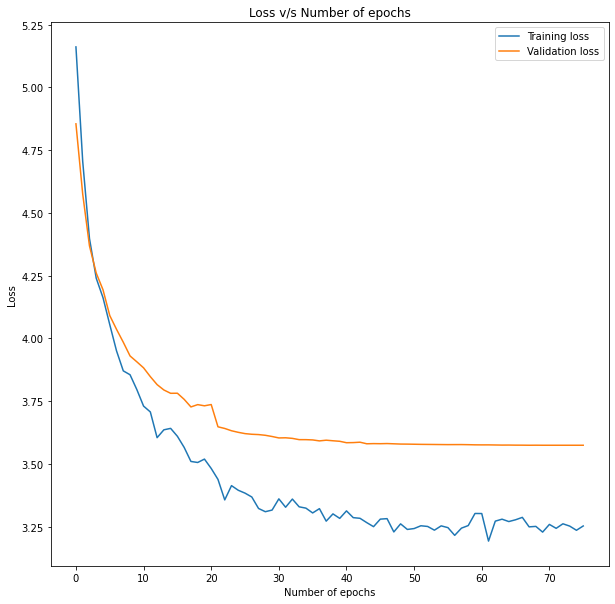

In [123]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Number of epochs")
plt.legend()

### PREDICTION

In [124]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

dog is running through the snow


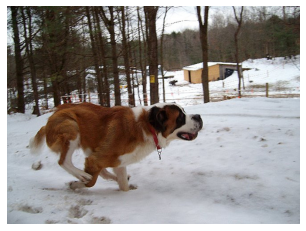

two football players in red and white uniforms are playing basketball


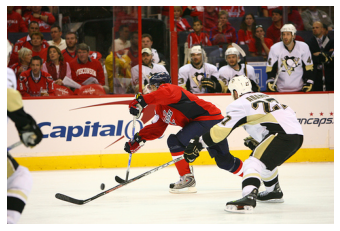

In [128]:
#PICK SOME RANDOM IMAGEES AD PREDICT
for i in range(2) :
    idx=np.random.randint(0,1000)
    all_images_name=list(encodedimg_valid.keys())
    img_name=all_images_name[idx]
    photo_2048=encodedimg_valid[img_name].reshape((1,2048))
    caption=predict_caption(photo_2048)
    i =plt.imread(IMG_PATH+img_name+".jpg")
    plt.imshow(i)
    print(caption)
    plt.axis('off')
    plt.show()